# Proportion analysis and DE scoring
## Load libraries and data

In [1]:
import sys
import os
os.environ['R_HOME'] = '/home/lfaure/miniconda3/envs/bulk/lib/R/'
import scanpy as sc
import numpy as np
import pandas as pd
import anndata2ri
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
import deseq2py as deseq2
sc.set_figure_params()

### Get bulk data

In [2]:
# data reading needs both adata_deseq2.h5ad and adata_deseq2.rds files
adata_bulk = deseq2.tl.read("adata_deseq2")

In [3]:
deseq2.tl.result(adata_bulk,'condition_Control_vs_Mutant')

Generating DE results
    done (0:00:02) --> added
    .uns['condition_Control_vs_Mutant']['Results'] table of differential expression results.


In [4]:
DE_res=adata_bulk.uns['condition_Control_vs_Mutant']['Results']

### Get ML10 dataset

In [5]:
from mtx_reader import read_mtx_gpu

In [6]:
adata=read_mtx_gpu("../../ML8-11/raw/matrix.mtx",transpose=True)
adata.obs_names=pd.read_csv("../../ML8-11/raw/barcodes.tsv",header=None)[0].values
adata.var_names=pd.read_csv("../../ML8-11/raw/features.tsv",header=None)[0].values

Reading mtx
    loading to device
    generating csr sparse


In [7]:
adata.obs["leiden"]=pd.read_table("../pagoda2/output/leiden_ML8-11.tsv",header=None).values.ravel().astype(str)
adata.obs["leiden"]=adata.obs["leiden"].astype("category")
adata.obs.leiden.value_counts()
adata=adata[adata.obs.leiden!="14"]
adata.obs["sampl"]=[s[0] for s in adata.obs_names.str.split("_")]
adata=adata[adata.obs.sampl=="ML10"]

/tmp/ipykernel_2414283/2687338059.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["sampl"]=[s[0] for s in adata.obs_names.str.split("_")]


In [8]:
adata

View of AnnData object with n_obs × n_vars = 23021 × 20201
    obs: 'leiden', 'sampl'

## Proportion analysis

In [9]:
import seaborn as sns
import scvelo as scv
def plot_prop(mat_prop,title="",return_df=False):
    scv.set_figure_params(figsize=(4,4),dpi=150)
    toplot=mat_prop.reset_index().melt(id_vars="index")
    toplot["cond"]=[s[0] for s in toplot["index"]]
    toplot.cond=toplot.cond.replace(["C","M"],["Control","Mutant"])
    ax=sns.stripplot(y="variable",x="value",hue="cond",palette=["tab:orange","tab:blue"],data=toplot)
    ax.set_ylabel("10X leiden cluster at E10")
    ax.set_xlabel("inferred bulk proportion")
    ax.set_title(title)
    if return_df:
        return toplot

### Run rnas-sieve

In [10]:
common=np.intersect1d(adata_bulk.var_names,adata.var_names)

adata=adata[:,common]
adata_bulk=adata_bulk[:,common]

In [11]:
counts_by_leiden=dict(zip(adata.obs.leiden.cat.categories,
         [adata[adata.obs.leiden==l].X.T.A for l in adata.obs.leiden.cat.categories]))

In [12]:
psis=np.array(adata_bulk.X.T)

In [13]:
from rnasieve.preprocessing import model_from_raw_counts
model, cleaned_psis = model_from_raw_counts(counts_by_leiden, psis)

In [14]:
res=model.predict(cleaned_psis)
res.index=adata_bulk.obs_names

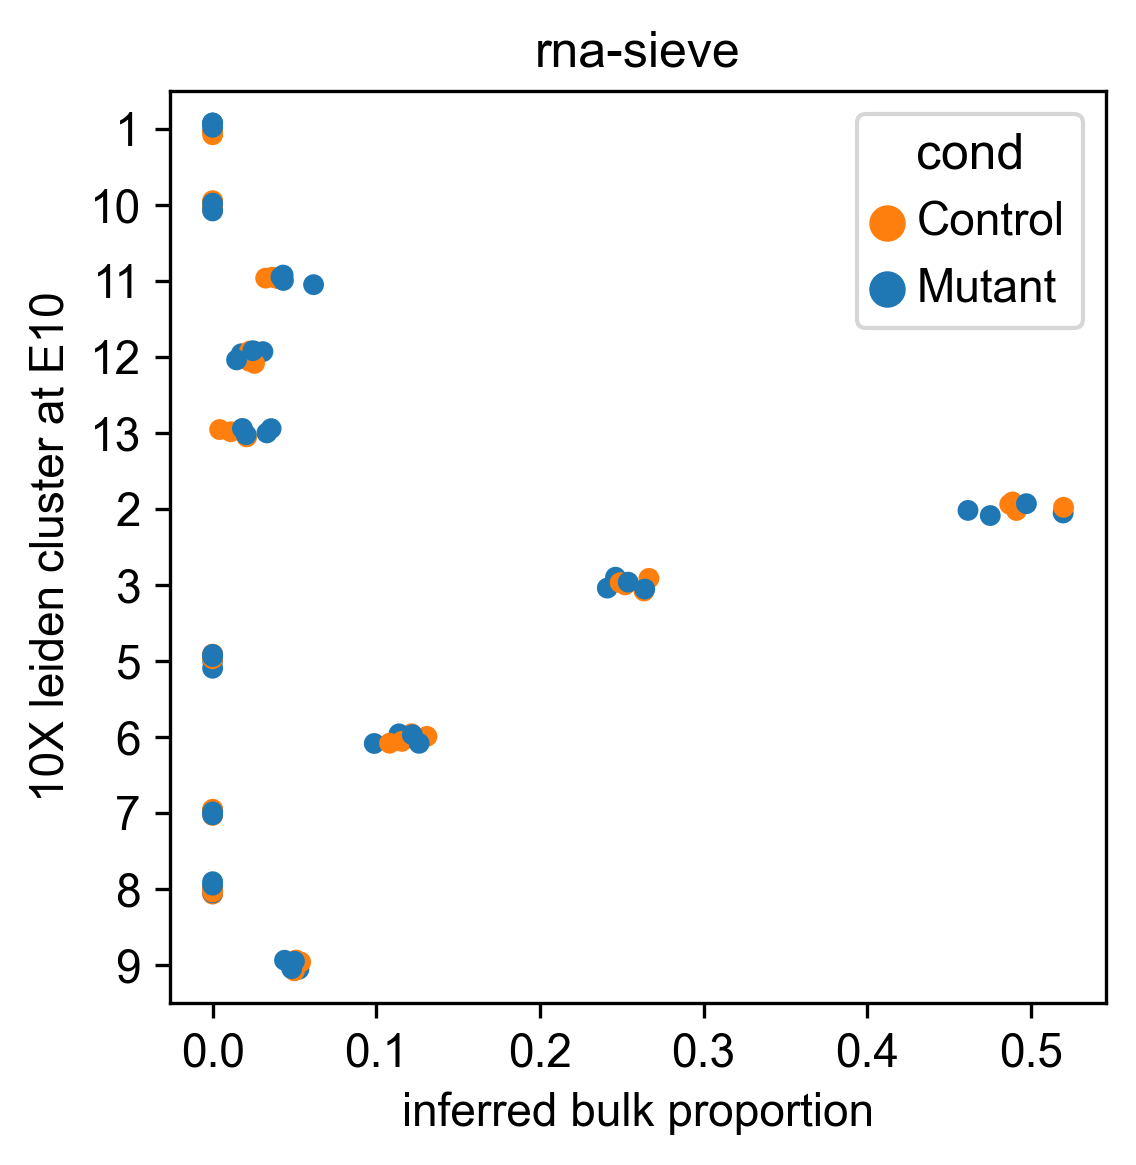

In [15]:
toplot=plot_prop(res,"rna-sieve",return_df=True)

In [16]:
from scipy.stats import ttest_ind
ttest_ind(toplot.loc[(toplot.variable=="13") & (toplot.cond=="Control")].value,
          toplot.loc[(toplot.variable=="13") & (toplot.cond=="Mutant")].value)

Ttest_indResult(statistic=-2.4006044272535116, pvalue=0.0532510054817516)

### loading ML10

In [17]:
adata_all=read_mtx_gpu("../../ML8-11/raw/matrix.mtx",transpose=True)
adata_all.obs_names=pd.read_csv("../../ML8-11/raw/barcodes.tsv",header=None)[0].values
adata_all.var_names=pd.read_csv("../../ML8-11/raw/features.tsv",header=None)[0].values
adata_all.obs["leiden"]=pd.read_table("../pagoda2/output/leiden_ML8-11.tsv",header=None).values.ravel().astype(str)
adata_all.obs["leiden"]=adata_all.obs["leiden"].astype("category")

Reading mtx
    loading to device
    generating csr sparse


In [18]:
adata=read_mtx_gpu("../../ML10/matrix.mtx.gz",transpose=True)
adata.obs_names=pd.read_csv("../../ML10/barcodes.tsv.gz",header=None)[0].values
adata.var_names=pd.read_csv("../../ML10/features.tsv.gz",sep="\t",header=None)[1].values

Reading mtx
    loading to device
    generating csr sparse


In [19]:
umap=pd.read_csv("../../ML10/UMAP_ML10.csv",index_col=0)
adata.obs_names="ML10_"+adata.obs_names
adata=adata[umap.index]
adata.obsm["X_umap"]=umap.values

In [20]:
sc.pp.normalize_total(adata,target_sum=1e3)
sc.pp.log1p(adata)

In [21]:
palette=["#4E79A7","#A0CBE8","#F28E2B","#59A14F","#8CD17D","#B6992D",
         "#F1CE63","#499894","#86BCB6","#E15759","#FF9D9A","#79706E","#BAB0AC"]

In [22]:
reordered=adata_all.obs.leiden.cat.categories[np.argsort(adata_all.obs.leiden.cat.categories.astype(int))]

In [23]:
adata_all.obs.leiden=adata_all.obs.leiden.cat.reorder_categories(reordered)

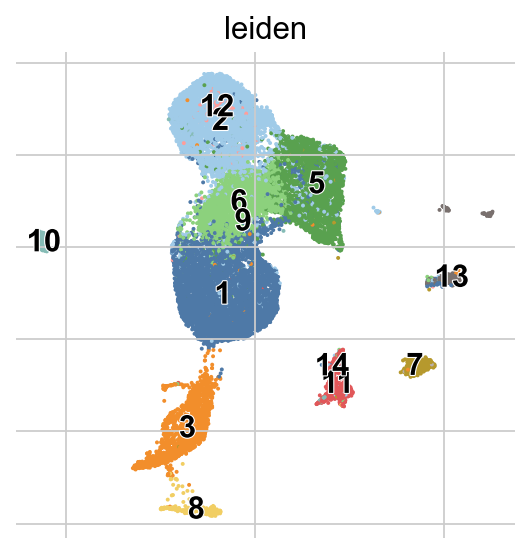

In [24]:
sc.set_figure_params()
adata.obs["leiden"]=adata_all.obs.leiden[adata.obs_names]
scv.pl.umap(adata,color="leiden",palette=palette)

In [25]:
adata.var_names_make_unique()

In [26]:
import scFates as scf

In [27]:
sc.pp.filter_genes(adata,min_cells=1)
scf.pp.find_overdispersed(adata)
adata.obsm["X_pca"]=sc.pp.pca(sc.pp.scale(adata[:,adata.var.highly_variable].X,copy=True))
sc.pp.neighbors(adata,n_neighbors=50,n_pcs=20)

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 1787 over-dispersed features (0:00:04) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



In [28]:
DE_res=DE_res.loc[DE_res.padj<0.05]
DE_res=DE_res.loc[DE_res.log2FoldChange.abs().sort_values(ascending=False).index]

In [29]:
CC=DE_res.index[(DE_res.log2FoldChange>0)]
M=DE_res.index[(DE_res.log2FoldChange<0)]

In [30]:
DE_res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Geneid,,,,,,
Gjb2,1979.567428,3.172278,0.439709,7.214489,5.413701e-13,3.570218e-10
Adcy8,62.977115,3.168130,0.966628,3.277505,1.047288e-03,2.720079e-02
Tlx1,41.793439,3.060296,0.338729,9.034650,1.645283e-19,2.772851e-16
Gjb6,726.914608,2.976166,0.512876,5.802892,6.518075e-09,1.432843e-06
Mfap5,27.757733,2.720252,0.433447,6.275852,3.477257e-10,1.034187e-07
...,...,...,...,...,...,...
Cnot1,17162.353932,-0.172586,0.051841,-3.329120,8.712071e-04,2.380986e-02
Sdha,11284.494635,-0.171910,0.052532,-3.272506,1.065987e-03,2.738535e-02
Chd8,8744.238676,-0.171033,0.056318,-3.036884,2.390375e-03,4.595337e-02


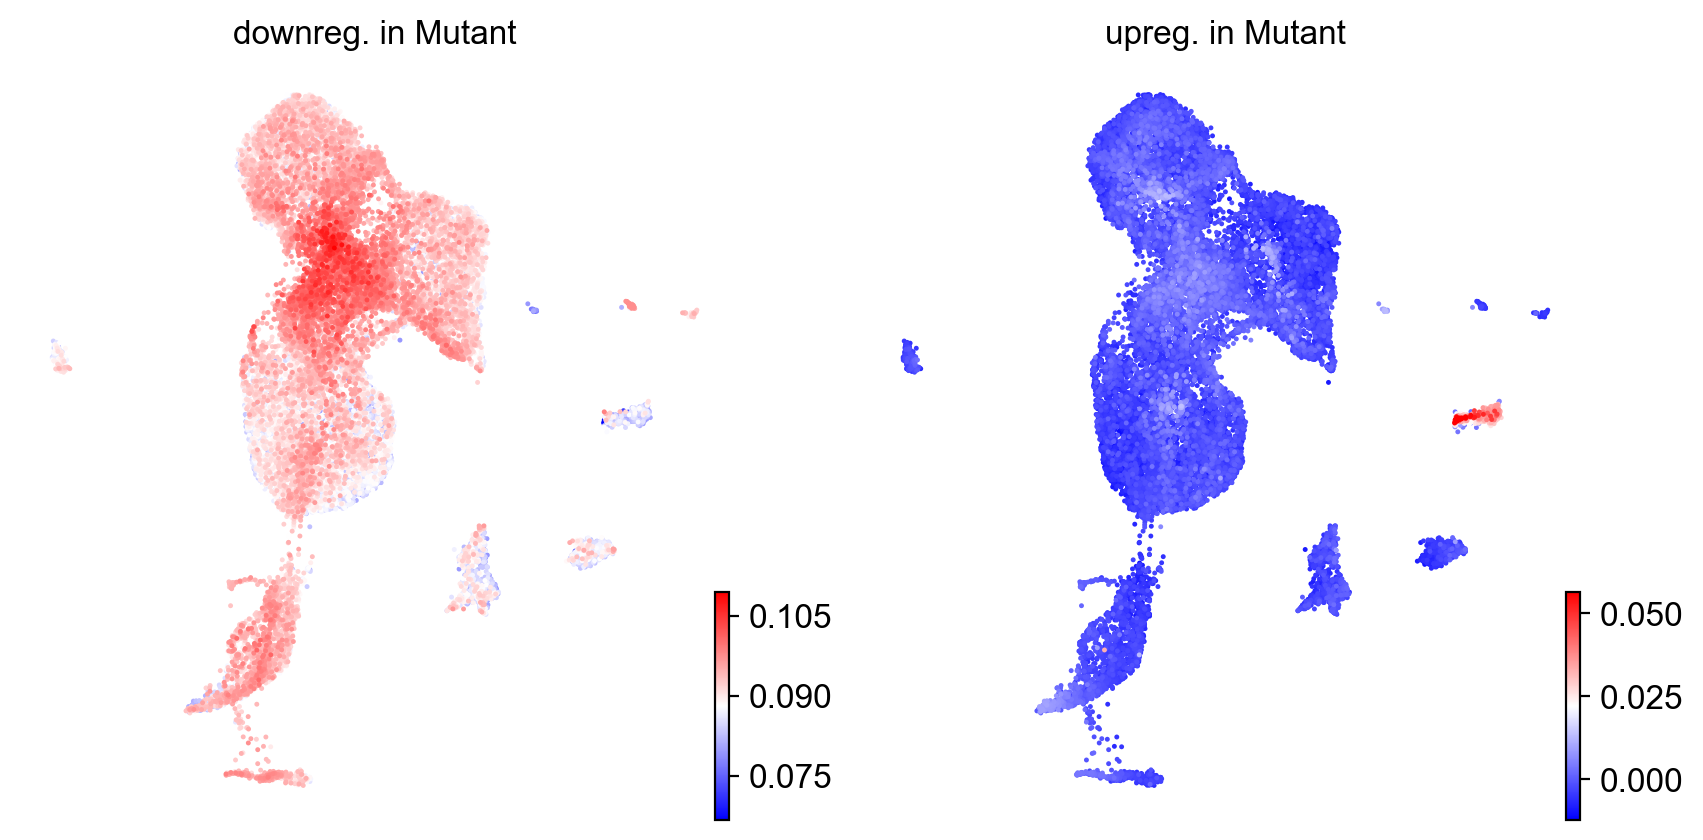

In [31]:
scv.set_figure_params(figsize=(5,5))
sc.tl.score_genes(adata,gene_list=M,score_name="upreg. in Mutant")
sc.tl.score_genes(adata,gene_list=CC,score_name="downreg. in Mutant")
scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

In [32]:
sc.tl.rank_genes_groups(adata,"leiden")

In [33]:
sc.get.rank_genes_groups_df(adata,"6").set_index("names").loc["Cdkn1c"]

scores            1.877043e+01
logfoldchanges    4.054559e-01
pvals             4.724148e-75
pvals_adj         1.378998e-73
Name: Cdkn1c, dtype: float64

In [34]:
DE_all=sc.get.rank_genes_groups_df(adata,["2","5","6","3"],pval_cutoff=0.05,log2fc_min=.4).set_index("names")
DE_all=DE_all.loc[DE_all.index.isin(DE_res.index)]
DE_all=DE_all.loc[DE_all.index]
DE_all=DE_all.sort_values("logfoldchanges")
DE_all=DE_all.reset_index()
DE_all=DE_all.drop_duplicates("names",keep="first").set_index("names")

In [35]:
DE_res["leiden"]=np.nan
DE_res.loc[DE_all.index,"leiden"]=DE_all.group

In [36]:
DE_res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,leiden
Geneid,,,,,,,
Gjb2,1979.567428,3.172278,0.439709,7.214489,5.413701e-13,3.570218e-10,6
Adcy8,62.977115,3.168130,0.966628,3.277505,1.047288e-03,2.720079e-02,NaN
Tlx1,41.793439,3.060296,0.338729,9.034650,1.645283e-19,2.772851e-16,NaN
Gjb6,726.914608,2.976166,0.512876,5.802892,6.518075e-09,1.432843e-06,2
Mfap5,27.757733,2.720252,0.433447,6.275852,3.477257e-10,1.034187e-07,2
...,...,...,...,...,...,...,...
Cnot1,17162.353932,-0.172586,0.051841,-3.329120,8.712071e-04,2.380986e-02,NaN
Sdha,11284.494635,-0.171910,0.052532,-3.272506,1.065987e-03,2.738535e-02,NaN
Chd8,8744.238676,-0.171033,0.056318,-3.036884,2.390375e-03,4.595337e-02,NaN


In [37]:
tfs=pd.read_csv("mm_mgi_tfs.txt",header=None)[0].values

In [38]:
DE_res["TF"]=False
DE_res.loc[DE_res.index.isin(tfs),"TF"]=True

In [39]:
DE_res2=DE_res.loc[~DE_res.leiden.isna()]

In [40]:
CC_res=DE_res2.loc[(DE_res2.log2FoldChange>0)]
M_res=DE_res2.loc[(DE_res2.log2FoldChange<0)]

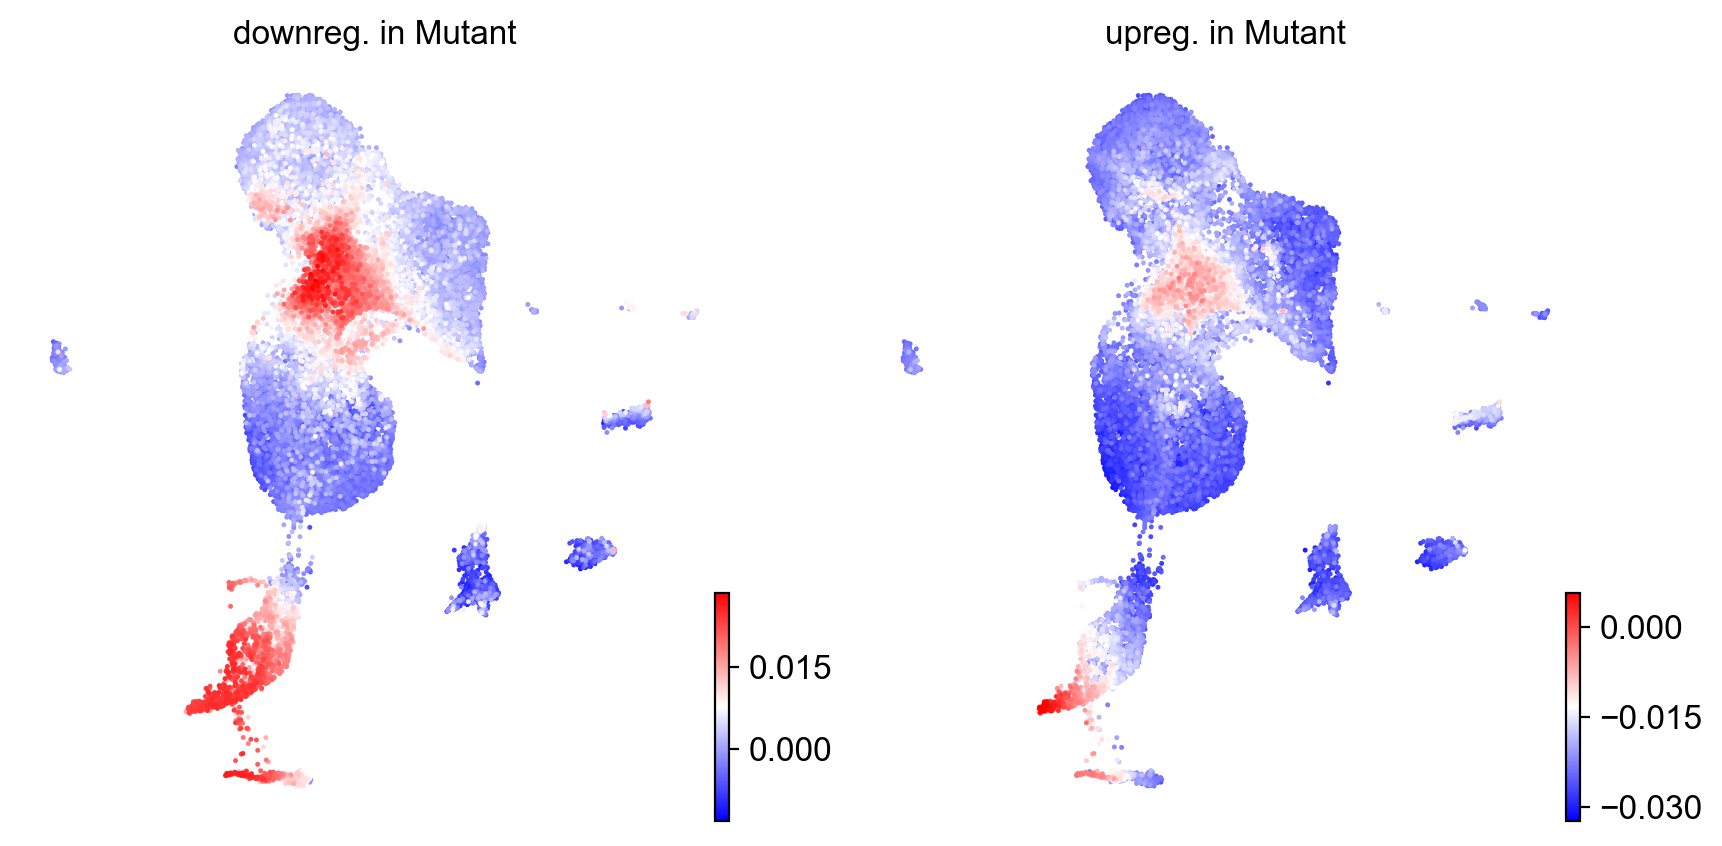

In [41]:
scv.set_figure_params(figsize=(5,5))
sc.tl.score_genes(adata,gene_list=M_res.index,score_name="upreg. in Mutant")
sc.tl.score_genes(adata,gene_list=CC_res.index,score_name="downreg. in Mutant")
scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

In [42]:
CC_res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,leiden,TF
Geneid,,,,,,,,
Gjb2,1979.567428,3.172278,0.439709,7.214489,5.413701e-13,3.570218e-10,6,False
Gjb6,726.914608,2.976166,0.512876,5.802892,6.518075e-09,1.432843e-06,2,False
Mfap5,27.757733,2.720252,0.433447,6.275852,3.477257e-10,1.034187e-07,2,False
Pbx1,9676.891394,2.156725,0.076159,28.318841,2.025943e-176,3.072950e-172,6,True
Krt15,1791.154733,2.087818,0.358966,5.816203,6.019947e-09,1.342802e-06,2,False
...,...,...,...,...,...,...,...,...
H1f0,25776.766676,0.199640,0.054640,3.653755,2.584332e-04,1.005106e-02,3,False
Isl1,2050.974543,0.198783,0.063775,3.116950,1.827327e-03,3.898298e-02,5,True
Trib2,3827.711417,0.188802,0.062874,3.002855,2.674597e-03,4.919256e-02,3,False


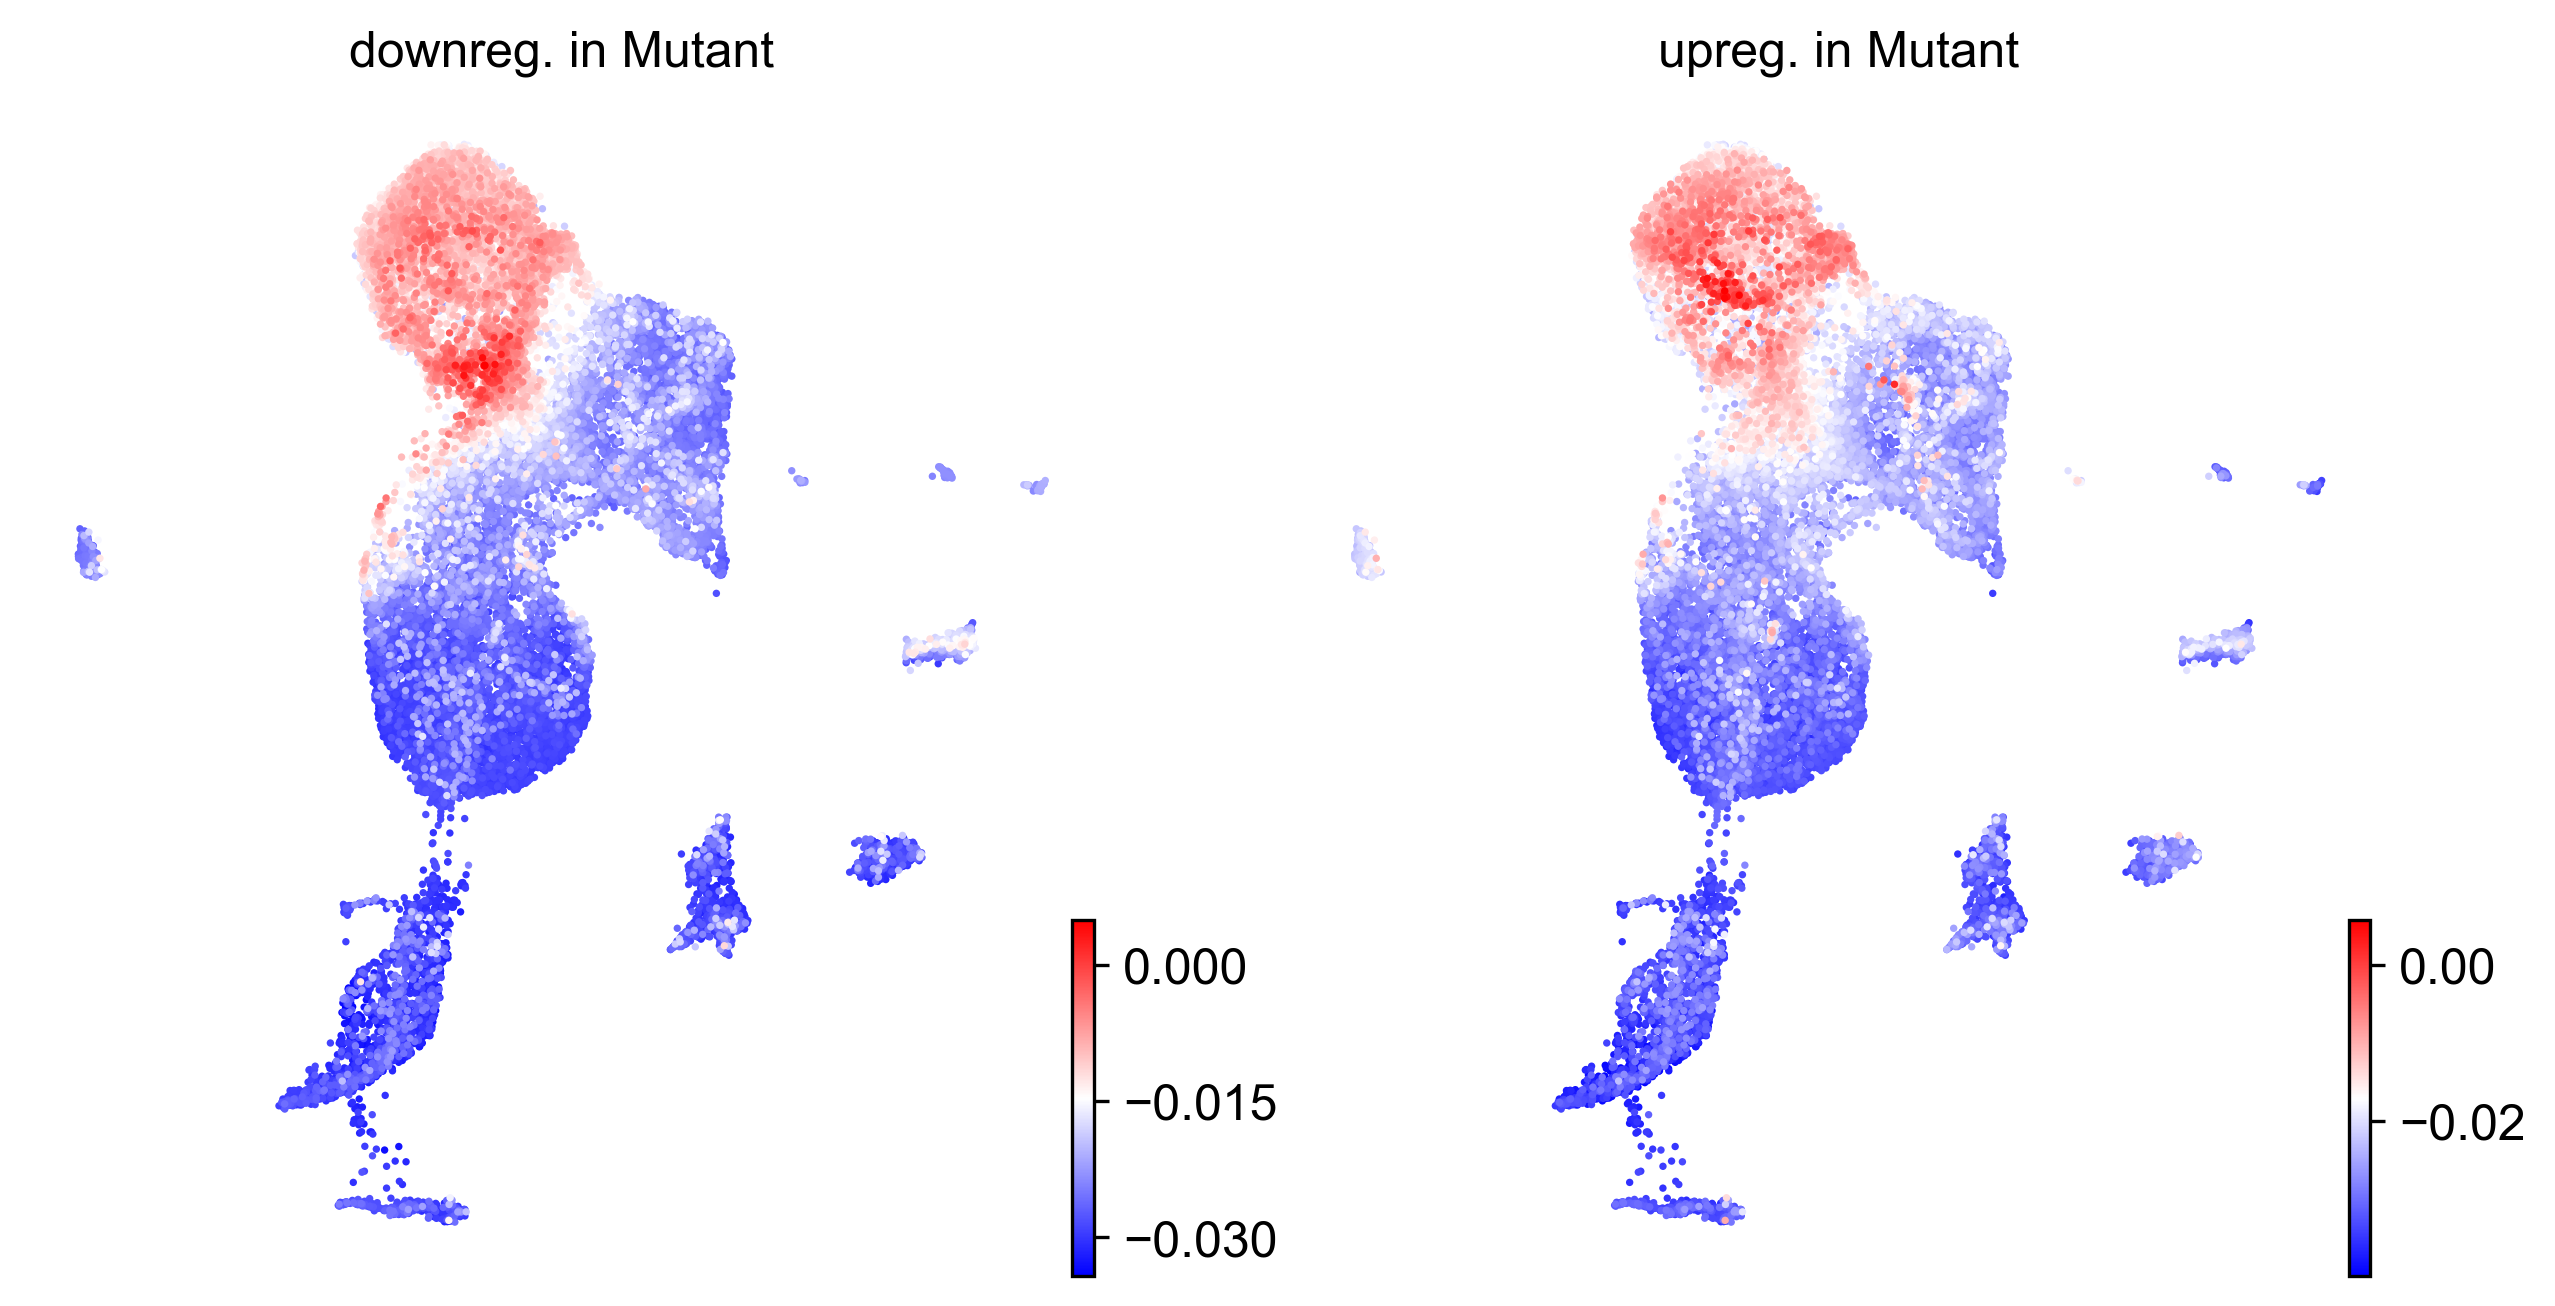

In [43]:
scv.set_figure_params(figsize=(5,5.2),dpi=150)
sc.tl.score_genes(adata,gene_list=M_res[M_res.leiden=="2"].index,score_name="upreg. in Mutant")
sc.tl.score_genes(adata,gene_list=CC_res[CC_res.leiden=="2"].index,score_name="downreg. in Mutant")
scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

In [44]:
print(f"{CC_res[(CC_res.leiden=='2')].shape[0]} genes, including: \n")
print("\n".join(CC_res[(CC_res.leiden=="2") & (CC_res.TF)].index.tolist()))

79 genes, including: 

Irx6
Hoxc13
Osr2
Arg1
Barx2
Vdr
Irx4
Bnc1
Lmx1b
Tfap2c
Msx2
Zbtb34


In [45]:
print(f"{M_res[(M_res.leiden=='2')].shape[0]} genes, including: \n")
print("\n".join(M_res[(M_res.leiden=="2") & (M_res.TF)].index.tolist()))

55 genes, including: 

Hmx1
Nr2f2
Nr2f1
Meis2


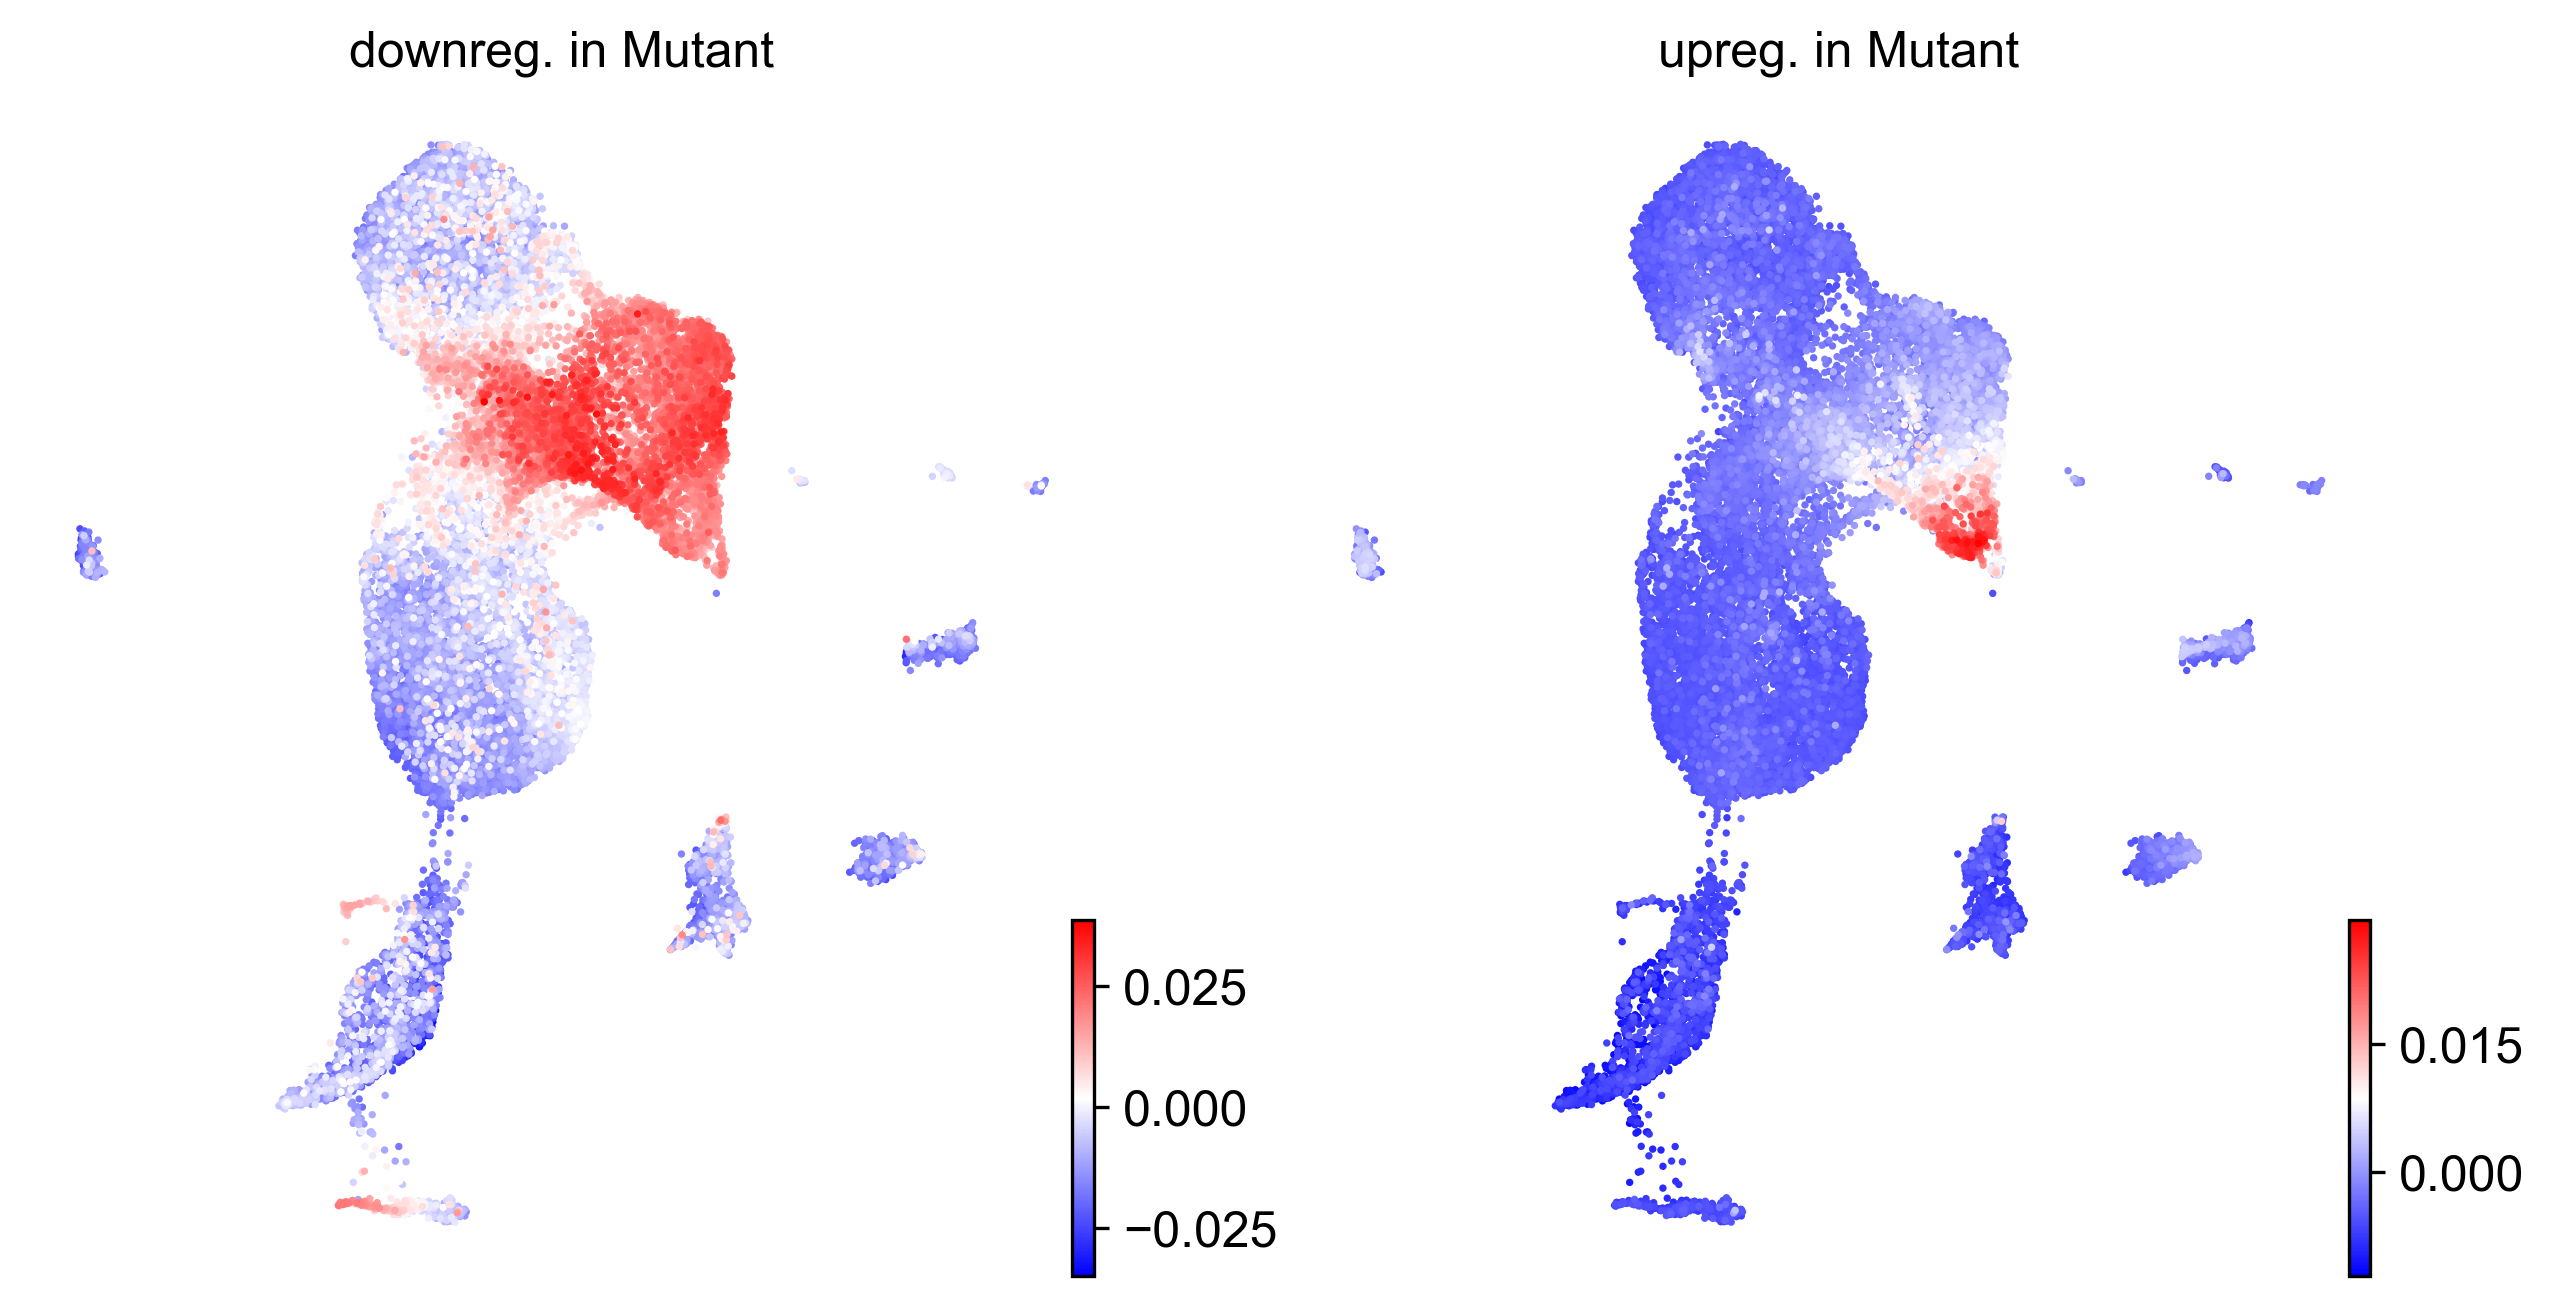

In [46]:
scv.set_figure_params(figsize=(5,5.2),dpi=150)
sc.tl.score_genes(adata,gene_list=M_res[M_res.leiden=="5"].index,score_name="upreg. in Mutant")
sc.tl.score_genes(adata,gene_list=CC_res[CC_res.leiden=="5"].index,score_name="downreg. in Mutant")
scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

In [47]:
print(f"{CC_res[(CC_res.leiden=='5')].shape[0]} genes, including: \n")
print("\n".join(CC_res[(CC_res.leiden=="5") & (CC_res.TF)].index.tolist()))

26 genes, including: 

Dmrt2
Isl2
Gli1
Isl1


In [48]:
print(f"{M_res[(M_res.leiden=='5')].shape[0]} genes, including: \n")
print("\n".join(M_res[(M_res.leiden=="5") & (M_res.TF)].index.tolist()))

36 genes, including: 

Creb3l2


In [49]:
#scv.set_figure_params(figsize=(3,5.2),dpi=150)
#sc.tl.score_genes(adata,gene_list=M_res[M_res.leiden=="1"].index,score_name="upreg. in Mutant")
#sc.tl.score_genes(adata,gene_list=CC_res[CC_res.leiden=="1"].index,score_name="downreg. in Mutant")
#scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

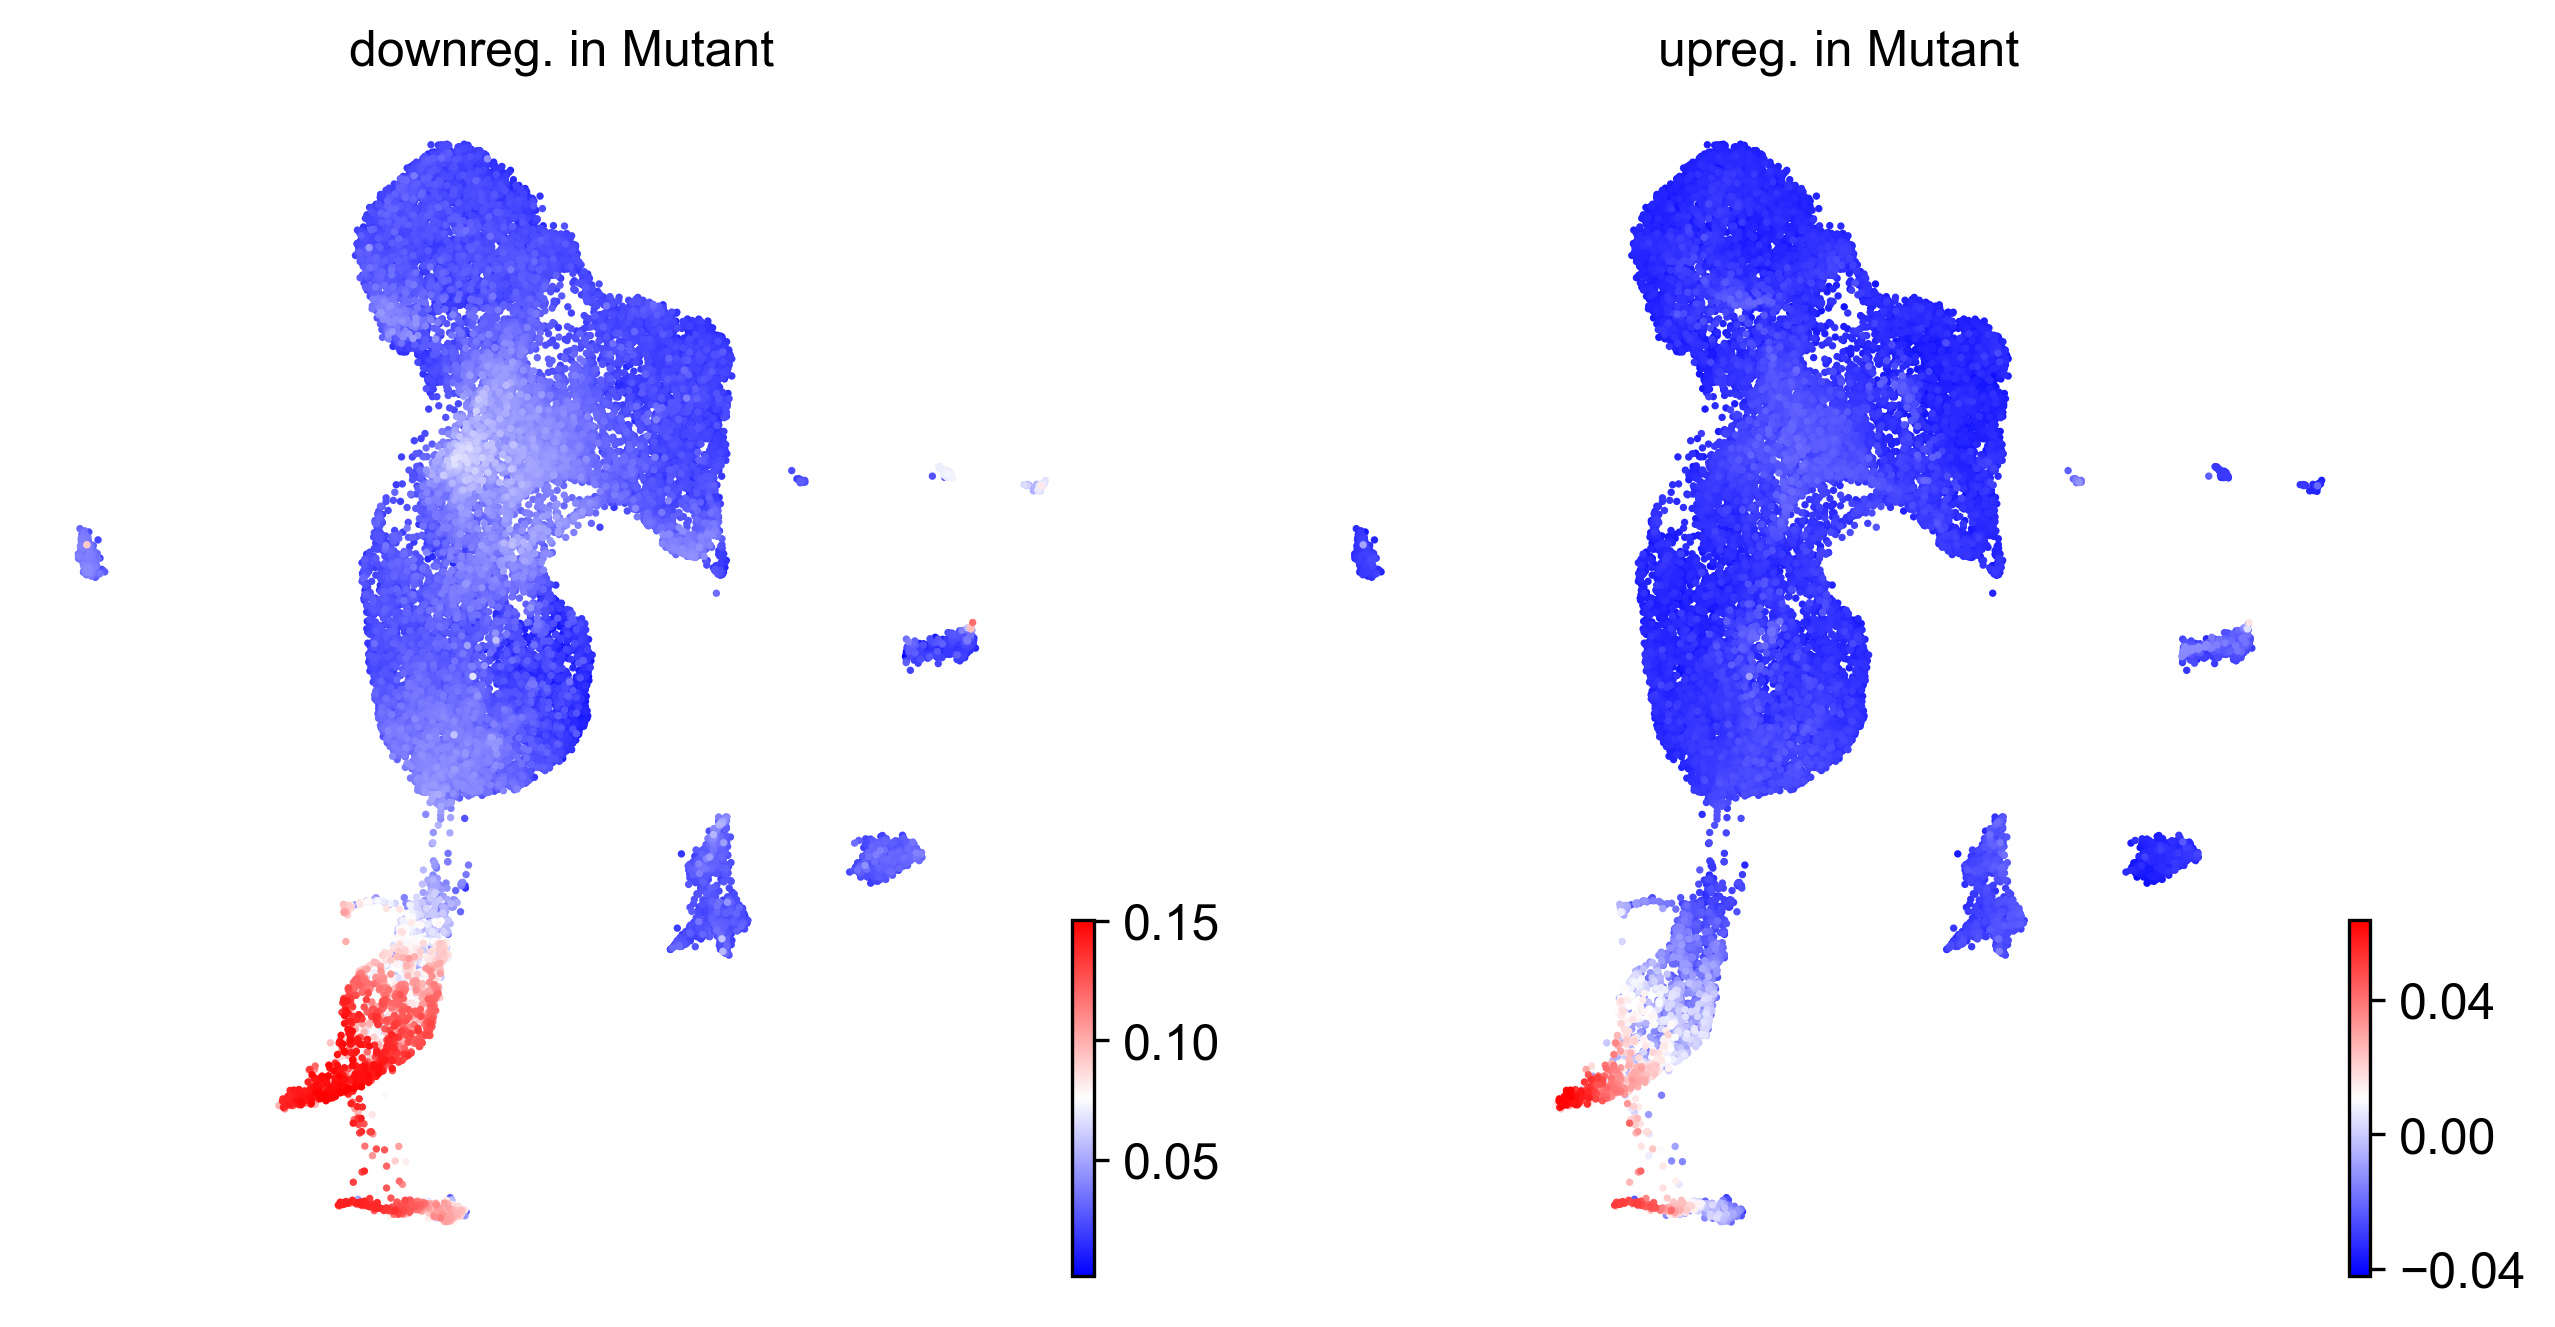

In [50]:
scv.set_figure_params(figsize=(5,5.2),dpi=150)
sc.tl.score_genes(adata,gene_list=M_res[M_res.leiden=="3"].index,score_name="upreg. in Mutant")
sc.tl.score_genes(adata,gene_list=CC_res[CC_res.leiden=="3"].index,score_name="downreg. in Mutant")
scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

In [51]:
print(f"{CC_res[(CC_res.leiden=='3')].shape[0]} genes, including: \n")
print("\n".join(CC_res[(CC_res.leiden=="3") & (CC_res.TF)].index.tolist()))

49 genes, including: 

Lhx3
Fezf2


In [52]:
print(f"{M_res[(M_res.leiden=='3')].shape[0]} genes, including: \n")
print("\n".join(M_res[(M_res.leiden=="3") & (M_res.TF)].index.tolist()))

58 genes, including: 

Prox1


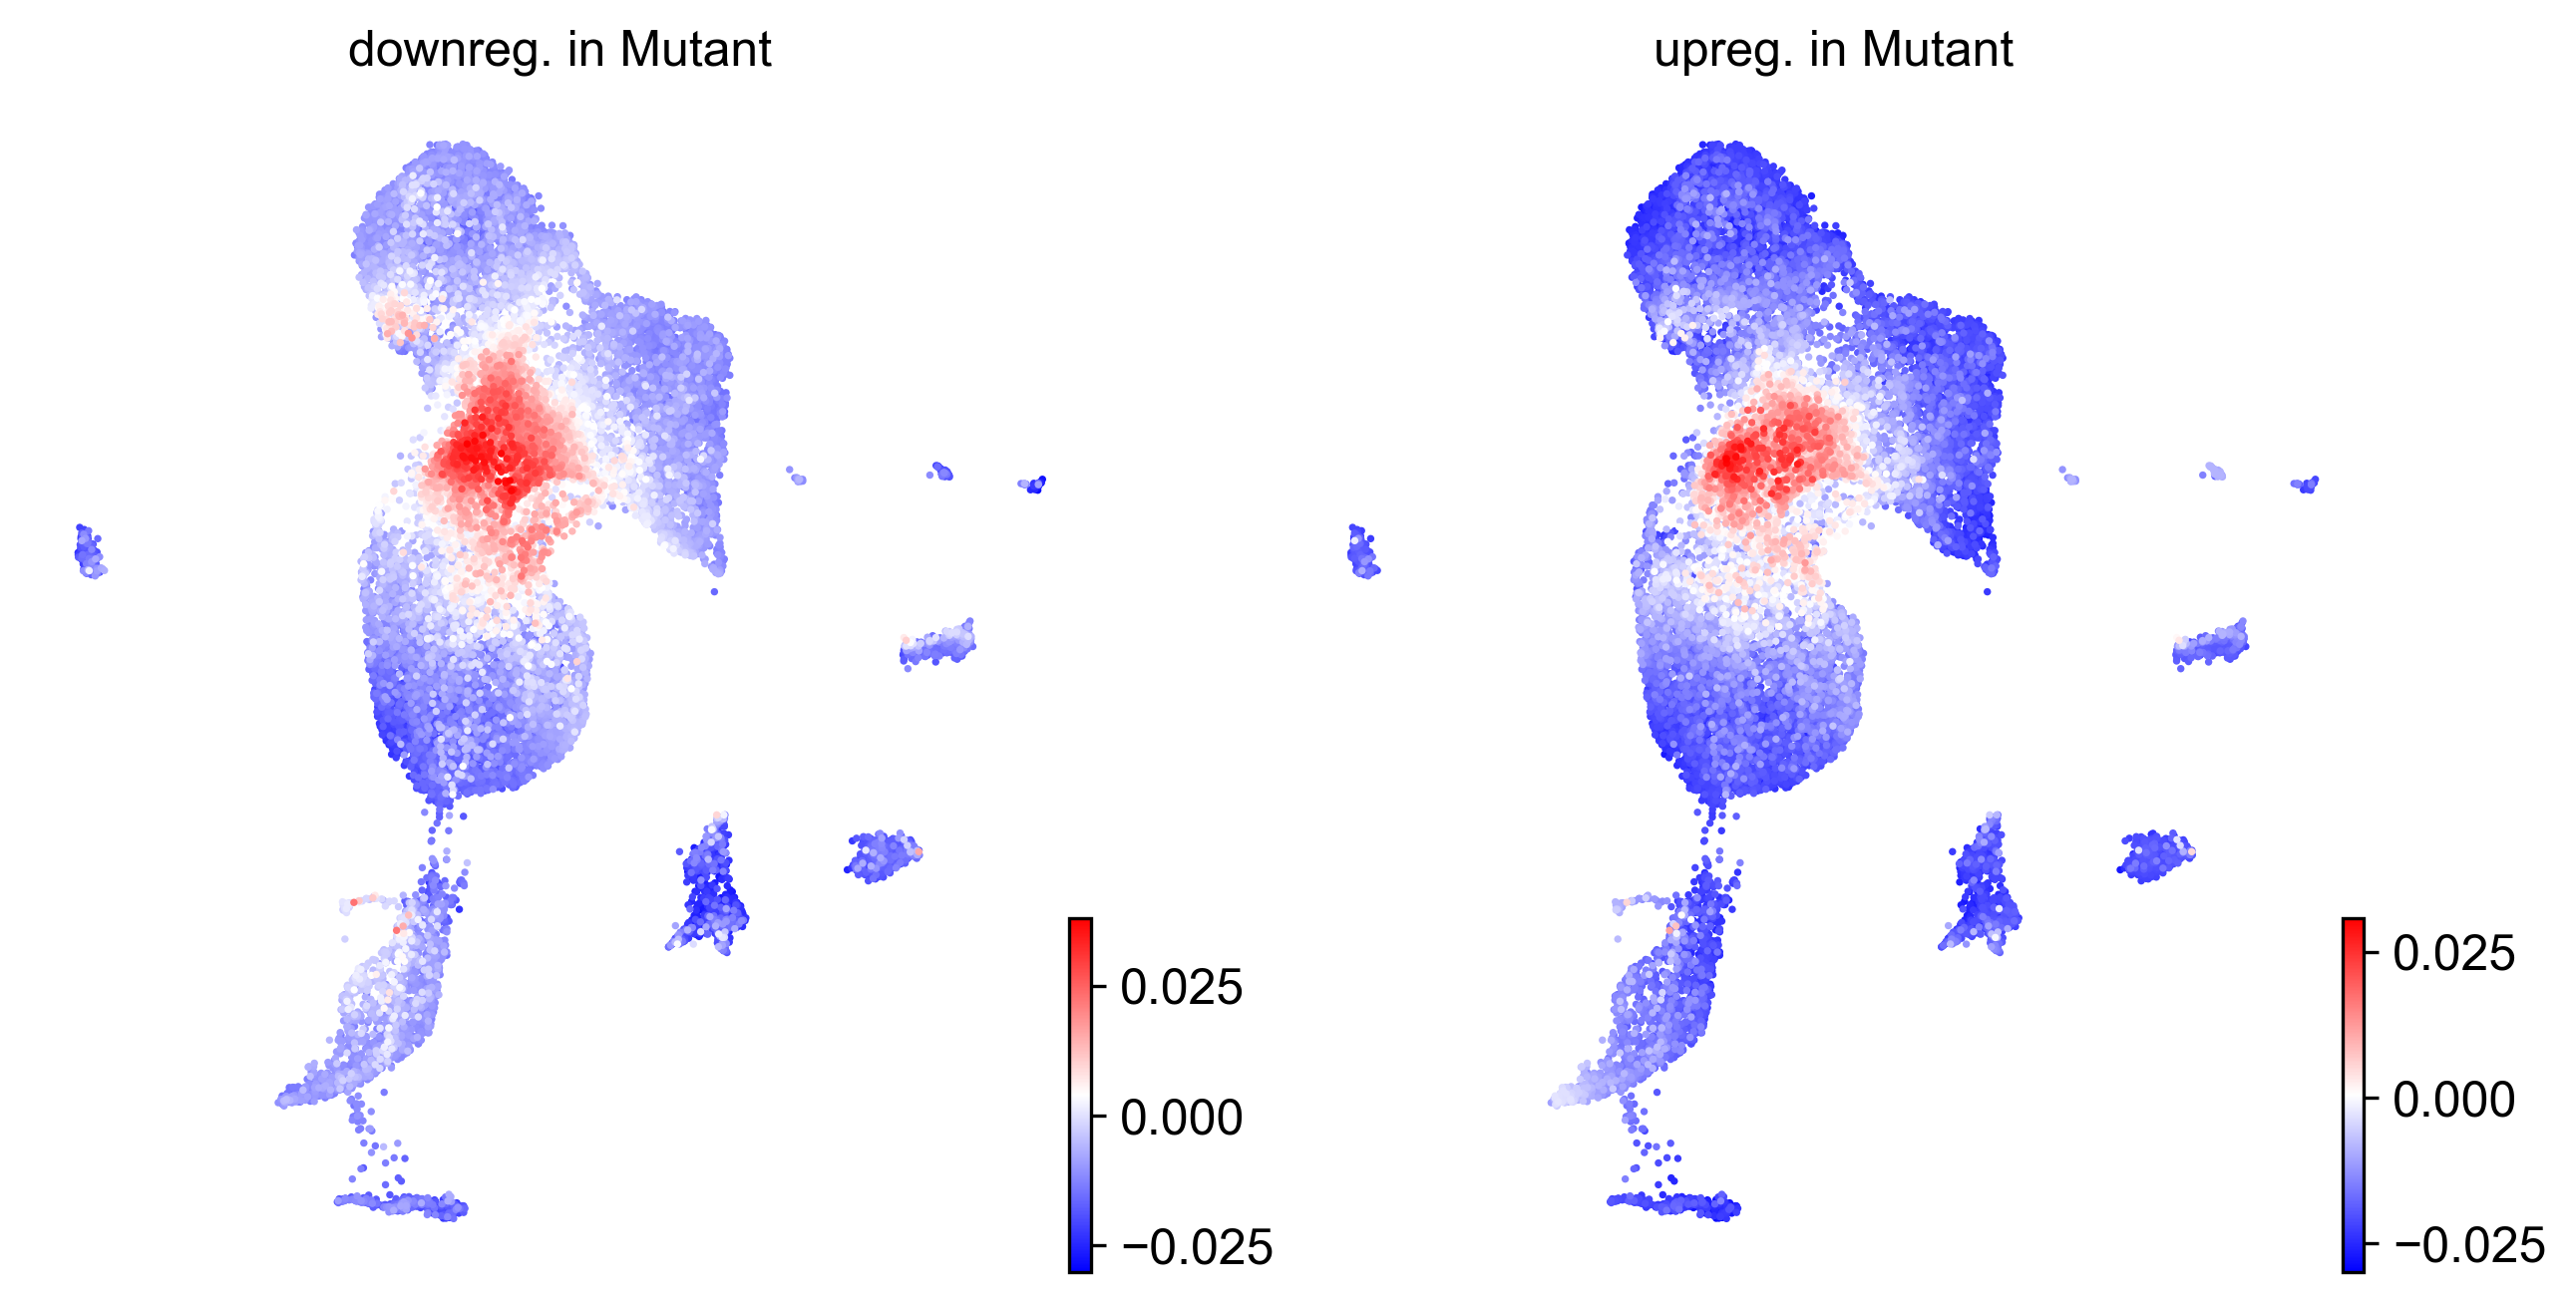

In [53]:
scv.set_figure_params(figsize=(5,5.2),dpi=150)
sc.tl.score_genes(adata,gene_list=M_res[M_res.leiden=="6"].index,score_name="upreg. in Mutant")
sc.tl.score_genes(adata,gene_list=CC_res[CC_res.leiden=="6"].index,score_name="downreg. in Mutant")
scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

In [54]:
print(f"{CC_res[(CC_res.leiden=='6')].shape[0]} genes, including: \n")
print("\n".join(CC_res[(CC_res.leiden=="6") & (CC_res.TF)].index.tolist()))

57 genes, including: 

Pbx1
Fosl2
Junb
Otx1
Smad7
Id1
Esrra
Tgif1


In [55]:
print(f"{M_res[(M_res.leiden=='6')].shape[0]} genes, including: \n")
print("\n".join(M_res[(M_res.leiden=="6") & (M_res.TF)].index.tolist()))

42 genes, including: 

Foxo1
Sox5
Id4
Foxo3


In [56]:
DE_final=pd.concat([M_res,CC_res.iloc[::-1]])
DE_final.log2FoldChange=-DE_final.log2FoldChange
DE_final.to_csv("filtered_DE.csv")

In [57]:
print("\n".join(M_res[M_res.leiden=="6"].index))

Aqp3
Jph2
Igfbp3
Rgs2
Dapk2
Stk32a
Gdf6
Parvb
Arhgef6
Fgf10
Camk1d
Sema6d
Lhfp
Tns4
Spry4
Rdh10
Cpm
Sgk1
Fut4
Nrip1
Gja1
Foxo1
Slc39a14
Arhgef28
Khdrbs3
Pik3r1
Sox5
Wdr19
Id4
Dpysl3
Klhl5
Tbc1d9
Samd5
Zfhx4
Igfbp4
Foxo3
Prrg3
Tle4
St6gal1
Itga6
Rmnd5a
Rnf150


In [58]:
print("\n".join(CC_res[CC_res.leiden=="6"].index))

Gjb2
Pbx1
Ptger4
Artn
Dapl1
Unc13c
Nipal2
2610035D17Rik
H2-T23
Krt19
Crtac1
Adamts18
Diras2
Prickle1
Ankrd22
Fosl2
Itgb6
Zfp385c
Has2
Smpdl3a
Fam162a
Ppp2r2b
Kif26a
Junb
Slc4a3
Dpp7
Cnksr1
Plekhn1
Cdkn1c
Smim20
Wdr45
Gad2
Sema3c
Otx1
Erich1
Smad7
Plxna2
Bnip3
Bnipl
Ntm
Id1
Rapgefl1
Efna1
Ier5
Btg1
Fgd2
Esrra
Ern1
Ankzf1
Tgif1
Mpped2
Mfap4
Ddit4
Pdgfc
Ypel1
Lmo4
Vgll4


In [59]:
print("\n".join(M_res[M_res.leiden=="2"].index))

Hapln1
Hmx1
Ccbe1
Steap3
Abcg5
Gm26688
Ccdc80
Wif1
Padi3
Angpt1
Ror1
Lama1
Cyp1b1
Art4
Nr2f2
Nr2f1
Serpinb6b
Arsi
Pde5a
Vgll3
Clic6
Kank4
Ttc39a
Ass1
Slit3
Vsir
Col8a2
Capn1
Necab1
Cyp26a1
Enpp1
Ptges
Nudt11
Frem2
Pros1
Fgfr3
Tgfbi
Prkce
Rbpms
Efna5
Egfl6
Tuft1
Col5a2
Gas7
Fat2
Dock4
Dock11
Gprc5c
Thbs1
Antxr1
Dnajc1
Cdh3
Prkci
Xpr1
Meis2


In [60]:
print("\n".join(CC_res[CC_res.leiden=="2"].index))

Gjb6
Mfap5
Krt15
Gabra1
Ppp1r1b
Col12a1
Irx6
Cd36
Hoxc13
Kcnj2
Sphkap
Chrm3
Osr2
Rab7b
Lgals7
Fgd5
Timp3
Cdh13
Arg1
Lpar3
Fam83c
Bmp6
Lgi2
Smagp
Piezo2
Ngf
Lrrtm1
Scnn1g
Etaa1os
Astn2
C130021I20Rik
Pla2r1
Slc35b3
Dlk2
Plxna4
Man1a
Barx2
Gimap9
Vdr
Slc7a10
Irx4
Tmem132c
Ccdc3
Aass
Rab29
Wnt3
Zcchc12
Lrp8os2
Exoc3l4
Krt1
Cryl1
Siah2
Gabrp
Plbd1
Avpi1
Wnt9b
Bnc1
St6gal2
Wnt4
Lmx1b
Gk
Tfap2c
Col4a6
Sema3a
Dock8
Inafm1
Pwwp2b
Wnt10a
Acpp
Nav2
Hras
Msx2
Ap4s1
Pdpn
Pdlim1
Col4a5
Tmem123
Ctsl
Zbtb34


In [61]:
print("\n".join(CC_res[CC_res.leiden=="5"].index))

Mgp
Rgs5
Sema3d
Chst2
Pde7b
Icam1
Dmrt2
Zfyve28
Isl2
Il1r1
Gli1
Lifr
Hspb1
Shh
Anxa2
Plxnc1
Atox1
Cox4i2
Cldn8
Baiap2
Ube2e2
Meg3
Vcan
Col11a1
Aprt
Isl1


In [62]:
DE_final

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,leiden,TF
Geneid,,,,,,,,
Gdnf,108.828221,1.618875,0.287706,-5.626839,1.835417e-08,3.663105e-06,5,False
Hapln1,4004.107885,1.573818,0.135015,-11.656582,2.123991e-31,8.054173e-28,2,False
Slc26a7,80.363414,1.338431,0.211885,-6.316775,2.670773e-10,8.267406e-08,5,False
Atp1a2,72.260621,1.203457,0.222608,-5.406174,6.438510e-08,1.085103e-05,5,False
Gfra2,314.088417,1.131976,0.163942,-6.904735,5.029723e-12,2.460995e-09,3,False
...,...,...,...,...,...,...,...,...
Krt15,1791.154733,-2.087818,0.358966,5.816203,6.019947e-09,1.342802e-06,2,False
Pbx1,9676.891394,-2.156725,0.076159,28.318841,2.025943e-176,3.072950e-172,6,True
Mfap5,27.757733,-2.720252,0.433447,6.275852,3.477257e-10,1.034187e-07,2,False


In [63]:
DE_res=DE_res.sort_values("log2FoldChange")

In [64]:
DE_res.log2FoldChange=-DE_res.log2FoldChange

In [65]:
DE_res.to_csv("unfiltered_DE.csv")